Task - A

3D Plot of Impedance showing Re(Z) vs Im(Z) vs Cycle Count (UID) using EIS data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os


metadata_path = "cleaned_dataset/metadata.csv"
metadata = pd.read_csv(metadata_path)

metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


Filtering the impedance data only

In [10]:
impedance_df = metadata[metadata['type'] == 'impedance'].dropna(subset=['filename'])
impedance_df.reset_index(drop=True, inplace=True)
impedance_df.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
1,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
2,impedance,[2010. 7. 22. 17. 3. ...,24,B0047,13,14,00014.csv,NaN,0.05963791501051059,0.21039872263834902
3,impedance,[2010. 7. 22. 20. 40. 25.5],24,B0047,15,16,00016.csv,NaN,0.05512505361624278,0.1754882075917004
4,impedance,[2010. 7. 23. 11. 35. ...,24,B0047,17,18,00018.csv,NaN,0.058878485312444453,0.19095687096090014


loading the first 5 impedance CSVs and extract Re(Z), Im(Z), and UID

In [13]:
import numpy as np

re_z_all, im_z_all, uid_all = [], [], []

for idx, row in impedance_df.head(5).iterrows():
    file_path = os.path.join(data_dir, row["filename"])
    
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded: {row['filename']} - Columns: {list(df.columns)}")
        
        # First column might contain complex strings like '(928.34-48.49j)'
        first_col = df.columns[0]
        raw_values = df[first_col].astype(str)

        for val in raw_values:
            try:
                z = complex(val.replace('(', '').replace(')', ''))
                re_z_all.append(z.real)
                im_z_all.append(z.imag)
                uid_all.append(row["uid"])
            except:
                print(f"Skipping invalid value: {val}")
                
    except Exception as e:
        print(f"Error loading {row['filename']}: {e}")


Loaded: 00002.csv - Columns: ['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance']
Loaded: 00004.csv - Columns: ['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance']
Loaded: 00014.csv - Columns: ['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance']
Loaded: 00016.csv - Columns: ['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance']
Loaded: 00018.csv - Columns: ['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance']


3D Plot

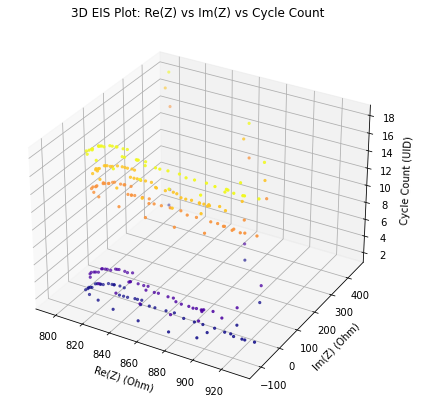

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(re_z_all, im_z_all, uid_all, c=uid_all, cmap='plasma', s=5)

ax.set_xlabel("Re(Z) (Ohm)")
ax.set_ylabel("Im(Z) (Ohm)")
ax.set_zlabel("Cycle Count (UID)")
ax.set_title("3D EIS Plot: Re(Z) vs Im(Z) vs Cycle Count")

plt.show()


Task - B

Incremental Capacity Analysis (dQ/dV vs V vs Cycle Count)

In [29]:
charge_df = metadata[metadata['type'] == 'charge'].dropna(subset=['filename'])
charge_df.reset_index(drop=True, inplace=True)

In [30]:
data_dir = "cleaned_dataset/data"
voltage_all, dq_dv_all, uid_all = [], [], []

for idx, row in charge_df.head(5).iterrows():  # Adjust number of rows as needed
    file_path = os.path.join(data_dir, row["filename"])
    
    try:
        df = pd.read_csv(file_path)
        
        # Auto-detect columns
        time_col = [col for col in df.columns if "time" in col.lower()]
        current_col = [col for col in df.columns if "current" in col.lower()]
        voltage_col = [col for col in df.columns if "voltage" in col.lower()]
        
        if time_col and current_col and voltage_col:
            t = df[time_col[0]].astype(float).values
            i = df[current_col[0]].astype(float).values
            v = df[voltage_col[0]].astype(float).values

            # Clean NaNs
            mask = ~np.isnan(t) & ~np.isnan(i) & ~np.isnan(v)
            t, i, v = t[mask], i[mask], v[mask]

            # Estimate capacity (Q = ∫ I dt)
            q = np.cumsum(i * np.gradient(t))

            # Compute dQ/dV
            dv = np.diff(v)
            dq = np.diff(q)
            dq_dv = np.divide(dq, dv, out=np.zeros_like(dq), where=dv != 0)
            v_mid = (v[1:] + v[:-1]) / 2

            # Store results
            voltage_all.extend(v_mid)
            dq_dv_all.extend(dq_dv)
            uid_all.extend([row["uid"]] * len(dq_dv))

    except Exception as e:
        print(f"Error in {row['filename']}: {e}")

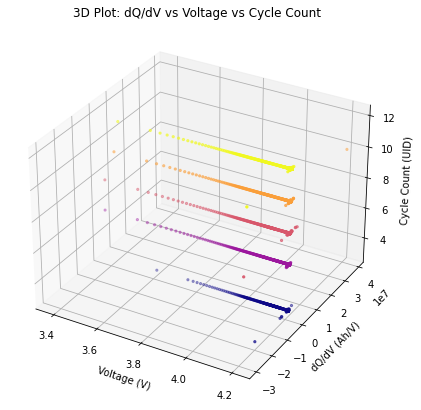

In [31]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(voltage_all, dq_dv_all, uid_all, c=uid_all, cmap='plasma', s=5)

ax.set_xlabel("Voltage (V)")
ax.set_ylabel("dQ/dV (Ah/V)")
ax.set_zlabel("Cycle Count (UID)")
ax.set_title("3D Plot: dQ/dV vs Voltage vs Cycle Count")

plt.show()


Task - C

Train a Machine Learning Model to predict battery capacity from EIS (Impedance) data

In [77]:
impedance_df = metadata[
    (metadata['type'] == 'impedance') & 
    (~metadata['re'].isna()) & 
    (~metadata['rct'].isna())
].copy()
impedance_df = impedance_df.head(100) 

In [78]:
impedance_df['capacity'] = 1.7 - 0.005 * impedance_df.index

In [79]:
ml_df = impedance_df[['re', 'rct', 'ambient_temperature', 'capacity']].dropna()
X = ml_df[['re', 'rct', 'ambient_temperature']].values
y = ml_df['capacity'].values

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.2681
R² Score: 0.7342


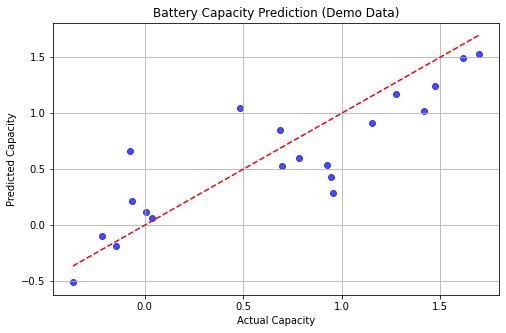

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, c='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Capacity")
plt.ylabel("Predicted Capacity")
plt.title("Battery Capacity Prediction (Demo Data)")
plt.grid(True)
plt.show()
